<h2>Hello it is data analysis of IMDB Movies dataset</h2>

<h4>Import modules and load dataset</h4>

In [27]:
import pandas as pd
import numpy as np
import spacy

In [28]:
data = pd.read_csv("IMDB Dataset.csv")

<h4>Lets look at the structure of dataset</h4>

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [31]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


<h4>There are some duplicates. Remove them</h4>

In [34]:
data.drop_duplicates(inplace=True)

In [35]:
data.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,I have been searching for the right words to d...,positive
freq,1,24884


In [37]:
data["sentiment"].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

<h4>Data balanced which is very good</h4>

In [38]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<h4>Let's make label numerical</h4>

In [39]:
data["sentiment"] = data["sentiment"].map({"positive": 1, "negative": 0})

In [40]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


<h4>The first sample look like</h4>

In [41]:
data["review"].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

<h4>Need to clean data. Import spacy!</h4>

In [62]:
import re
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [43]:
parser = English()
punctuations = string.punctuation

In [44]:
def spacy_text_normalizer(text):
    text = re.sub(r"<.*>", "", text) #Remove all tags
    tokens = parser(text) #Get doc from text
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ] #Normalize words
    tokens = [ word for word in tokens if word not in STOP_WORDS and word not in punctuations ] #Remove stop words and punctuation
    return " ".join(tokens)

<h4>Cleaned data looks like. Much better</h4>

In [45]:
%%time
spacy_text_normalizer(data["review"].iloc[0])

CPU times: user 5.54 ms, sys: 0 ns, total: 5.54 ms
Wall time: 5.52 ms


'reviewers mentioned watching 1 oz episode hooked right exactly happened main appeal fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance ... oz mess episode saw struck nasty surreal ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order away mannered middle class inmates turned prison bitches lack street skills prison experience watching oz comfortable uncomfortable viewing .... thats touch darker'

<h4>Let's clean all the data</h4>

In [50]:
%%time
clean_data = pd.DataFrame({"review": data["review"].apply(spacy_text_normalizer), "sentiment": data["sentiment"]})
clean_data.to_csv("Clean_IMDB.csv")

CPU times: user 58.7 s, sys: 90.2 ms, total: 58.8 s
Wall time: 58.9 s


In [51]:
clean_data.head()

,review,sentiment
0,reviewers mentioned watching 1 oz episode hook...,1
1,wonderful little production realism comes home...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


<h4>What about the distribution of words in different classes</h4>

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
def get_popular_words(data, count=10):
    vec = CountVectorizer().fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [54]:
positive_reviews_words = get_popular_words(clean_data[clean_data["sentiment"] == 1]["review"])
negative_reviews_words = get_popular_words(clean_data[clean_data["sentiment"] == 0]["review"])

In [55]:
import matplotlib.pyplot as plt

<BarContainer object of 10 artists>

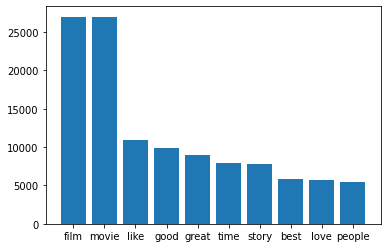

In [56]:
plt.bar([word[0] for word in positive_reviews_words], [word[1] for word in positive_reviews_words])

<BarContainer object of 10 artists>

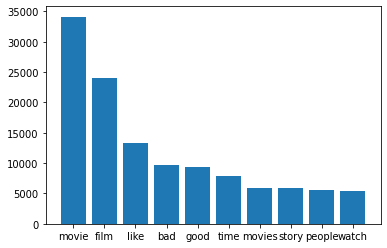

In [57]:
plt.bar([word[0] for word in negative_reviews_words], [word[1] for word in negative_reviews_words])

<h4>Looks very similar. So i think all difference will be in bigrams</h4>

In [58]:
def get_popular_bigrams(data, count=10):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [59]:
positive_reviews_bigrams = get_popular_bigrams(clean_data[clean_data["sentiment"] == 1]["review"], count=6)
negative_reviews_bigrams = get_popular_bigrams(clean_data[clean_data["sentiment"] == 0]["review"], count=6)

<BarContainer object of 6 artists>

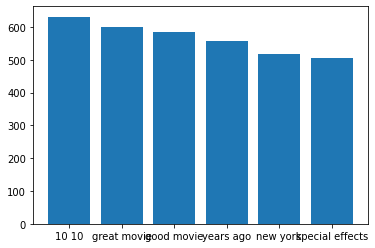

In [60]:
plt.bar([bigram[0] for bigram in positive_reviews_bigrams], [bigram[1] for bigram in positive_reviews_bigrams])

<BarContainer object of 6 artists>

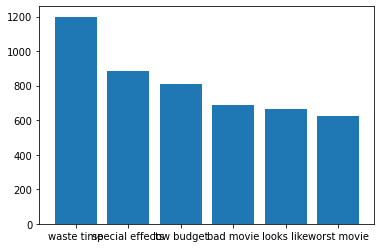

In [61]:
plt.bar([bigram[0] for bigram in negative_reviews_bigrams], [bigram[1] for bigram in negative_reviews_bigrams])

<h4>Much better. Most likely, the final model will need to be trained on bigrams.</h4>